In [1]:
## Boiler plate code common to many notebooks.  See the TestFilesCommonCode.ipynb for details
from __future__ import print_function
%run TestFilesCommonCode.ipynb

SimpleITK Version: 0.9.1
Compiled: Sep 28 2015 10:07:41



In [2]:
import os
import glob
import sys

#\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/
#####################################################################################
#     Prepend the shell environment search paths
PROGRAM_PATHS = '/scratch/NAMICExternalProjects/release-20160523/bin'
#PROGRAM_PATHS = '/scratch/BS/release-BSR/bin'
PROGRAM_PATHS = PROGRAM_PATHS.split(':')
PROGRAM_PATHS.extend(os.environ['PATH'].split(':'))
os.environ['PATH'] = ':'.join(PROGRAM_PATHS)

CUSTOM_ENVIRONMENT=dict()

import SimpleITK as sitk
import nipype
from nipype.interfaces.base import CommandLine, CommandLineInputSpec, TraitedSpec, File, Directory
from nipype.interfaces.base import traits, isdefined, BaseInterface
from nipype.interfaces.utility import Merge, Split, Function, Rename, IdentityInterface
import nipype.interfaces.io as nio   # Data i/oS
import nipype.pipeline.engine as pe  # pypeline engine
from nipype.interfaces.freesurfer import ReconAll
from nipype.interfaces.ants import DenoiseImage
from nipype.interfaces.semtools import *

# Platform specific information
#     Prepend the python search paths
#PYTHON_AUX_PATHS = '/scratch/BS/BRAINSTools/AutoWorkup'
PYTHON_AUX_PATHS = '/scratch/SuperResolution/BRAINSSuperResolution/HCPWorkflows/:/scratch/wmql/tract_querier/tract_querier/'
PYTHON_AUX_PATHS = PYTHON_AUX_PATHS.split(':')
PYTHON_AUX_PATHS.extend(sys.path)
sys.path = PYTHON_AUX_PATHS

In [3]:
from tract_querier.nipype.wmql import TractQuerier

In [4]:
# gs: gold standard
# in: input
# gs_cst_left_fn = '/scratch/TESTS/IpythonNotebook/20160615_HCPWF/mainWF/Outputs_July27/WMQL/Baseline_query_cst.left.vtp'
# gs_cst_right_fn = '/scratch/TESTS/IpythonNotebook/20160615_HCPWF/mainWF/Outputs_July27/WMQL/Baseline_query_cst.right.vtp'

# sr_cst_left_fn = '/scratch/TESTS/IpythonNotebook/20160615_HCPWF/mainWF/Outputs_July27/WMQL/WTV_query_cst.left.vtp'
# sr_cst_right_fn = '/scratch/TESTS/IpythonNotebook/20160615_HCPWF/mainWF/Outputs_July27/WMQL/WTV_query_cst.right.vtp'

gs_cst_left_fn = '/scratch/TESTS/IpythonNotebook/20160615_HCPWF/mainWF/test_wmql/July31/Baseline_query_cst.left.vtp'
gs_cst_right_fn = '/scratch/TESTS/IpythonNotebook/20160615_HCPWF/mainWF/test_wmql/July31/Baseline_query_cst.right.vtp'

sr_cst_left_fn = '/scratch/TESTS/IpythonNotebook/20160615_HCPWF/mainWF/test_wmql/July31/IFFT_query_cst.left.vtp'
sr_cst_right_fn = '/scratch/TESTS/IpythonNotebook/20160615_HCPWF/mainWF/test_wmql/July31/IFFT_query_cst.right.vtp'

In [5]:
def CSTOverlap(gs_cst_left, gs_cst_right, sr_cst_left, sr_cst_right):
    # gs: gold standard, sr: super-resolution reconstructed
    import os
    #########
    def ComputeBhattacharyyaCoeficient(gs_bundle,sr_bundle):
        from tract_querier import tract_math, tractography
        import numpy as np
        ###
        def AlignFiber(tract):
            out_tract = tract
            vecs = np.diff(tract, axis=0)
            avg_vec = np.mean(vecs, axis=0)
            dots = np.array([ np.dot(avg_vec,[1,0,0]), np.dot(avg_vec,[0,1,0]), np.dot(avg_vec,[0,0,1]) ])
            idx = np.argmax(np.abs(dots))
            if (dots[idx] < 0):
                out_tract = tract[::-1]
            return out_tract
        #
        def InterpolateFiber(tract):
            new_tract = tract
            # find point distances
            d = np.diff(tract, axis=0)
            pointdists = np.hypot(d[:,0], d[:,1], d[:,2])
            dist_threshold = min(pointdists.sum()/len(pointdists),1)
            offset = 0
            for i in xrange(len(pointdists)):
                if pointdists[i] > dist_threshold:
                    new_p = (tract[i+1]+tract[i])/2
                    new_tract = np.insert(new_tract,i+1+offset,new_p,axis=0)
                    offset += 1
            return new_tract
        #
        def returnBundlePoints(bundle):
            in_tractography = tractography.tractography_from_files(bundle)
            tracts = in_tractography.tracts()
            ## sort all tracts direction to positive coordinate of their dominant orientation
            ## then interpolate tracts to make sure they are approximately equally placed
            for i in xrange(len(tracts)):
                tracts[i] = AlignFiber(tracts[i])
                tracts[i] = InterpolateFiber(tracts[i])
            #
            tracts_last_quarter = [tracts[i][4*len(tracts[i])/5:] for i in xrange(len(tracts))]
            #
            pts = np.vstack(tracts)
            pts_last_quarter = np.vstack(tracts_last_quarter)
            return pts, pts_last_quarter
        #
        def returnBhattCoef(gs_pts,sr_pts):
            from scipy import stats
            gs_xyz = np.array([np.linspace(gs_pts.min(0)[i],gs_pts.max(0)[i],100) for i in xrange(3)])
            sr_xyz = np.array([np.linspace(sr_pts.min(0)[i],sr_pts.max(0)[i],100) for i in xrange(3)])
            #
            gs_kde = np.array([ stats.gaussian_kde(gs_pts[:,i]) for i in xrange(3) ])
            gs_p = np.array([ gs_kde[i](gs_xyz[i]) for i in xrange(3) ])
            gs_p = np.array([gs_p[i]/gs_p.sum(1)[i] for i in xrange(3)])
            #
            sr_kde = np.array([ stats.gaussian_kde(sr_pts[:,i]) for i in xrange(3) ])
            sr_p = np.array([ sr_kde[i](sr_xyz[i]) for i in xrange(3) ])
            sr_p = np.array([sr_p[i]/sr_p.sum(1)[i] for i in xrange(3)])
            #
            coefs = np.array([ np.sqrt(gs_p[i]*sr_p[i]).sum() for i in xrange(3) ]) 
            return coefs.mean()
        ###
        [gs_pts, gs_pts_last_quarter] = returnBundlePoints(gs_bundle)
        [sr_pts, sr_pts_last_quarter] = returnBundlePoints(sr_bundle)
        #
        coef = returnBhattCoef(gs_pts,sr_pts)
        coef_last_quarter = returnBhattCoef(gs_pts_last_quarter,sr_pts_last_quarter)
        return [coef,coef_last_quarter] 
    #########
    def writeLabelStatistics(filename,statsList):
        import csv
        label = os.path.splitext(os.path.basename(filename))[0].split('_',1)[0]
        with open(filename, 'wb') as lf:
            headerdata = [['#Label', 'cst_left', 'cst_right', 'cst', 'cst_left_top', 'cst_right_top', 'cst_top']]
            wr = csv.writer(lf, delimiter=',')
            wr.writerows(headerdata)
            wr.writerows([[label] + statsList])
    #########
    # compute Bhattacharyya Coeficient for cst.left/right/total
    bc_l,bc_l_q = ComputeBhattacharyyaCoeficient(gs_cst_left,sr_cst_left)
    bc_r,bc_r_q = ComputeBhattacharyyaCoeficient(gs_cst_right,sr_cst_right)
    bc_total = (bc_l + bc_r)/2.0
    bc_total_q = (bc_l_q + bc_r_q)/2.0
    statsList = [format(bc_l,'.4f'), format(bc_r,'.4f'), format(bc_total,'.4f'), format(bc_l_q,'.4f'), format(bc_r_q,'.4f'), format(bc_total_q,'.4f')]
    # create output file name
    srfn = os.path.basename(sr_cst_left)
    srfnbase = os.path.splitext(srfn)[0]
    srLabel = srfnbase.split('_',1)[0]
    fn = srLabel + '_BhattacharyyaCoeficient.csv'
    output_csv_file = os.path.join(os.getcwd(), fn)
    # write the stats list
    writeLabelStatistics(output_csv_file,statsList)
    assert os.path.isfile(output_csv_file), "Output Bhattacharyya coeficient file is not found: %s" % output_csv_file
    return output_csv_file

In [6]:
fn = CSTOverlap(gs_cst_left_fn, gs_cst_right_fn, sr_cst_left_fn, sr_cst_right_fn)
print(fn)

/Volumes/scratch/Ipython_conda/SimpleITK-Notebook-Answers/IFFT_BhattacharyyaCoeficient.csv


In [ ]:
# compare FA 

In [ ]:
from tract_querier import tract_math, tractography

In [ ]:
bundle = gs_cst_left_fn

In [ ]:
in_tractography = tractography.tractography_from_files(bundle)
tracts = in_tractography.tracts()
tracts_data = in_tractography.tracts_data()

In [ ]:
for key in tracts_data:
    print(key)

In [ ]:
FA1 = tracts_data['FA1']
print(len(FA1[0]))

# Plot tracts

In [7]:
from tract_querier import tract_math, tractography
import numpy as np
###
def AlignFiber(tract):
    out_tract = tract
    vecs = np.diff(tract, axis=0)
    avg_vec = np.mean(vecs, axis=0)
    dots = np.array([ np.dot(avg_vec,[1,0,0]), np.dot(avg_vec,[0,1,0]), np.dot(avg_vec,[0,0,1]) ])
    idx = np.argmax(np.abs(dots))
    if (dots[idx] < 0):
    #if (dots[2] < 0):
        out_tract = tract[::-1]
    return out_tract
#
def InterpolateFiber(tract):
    new_tract = tract
    # find point distances
    d = np.diff(tract, axis=0)
    pointdists = np.hypot(d[:,0], d[:,1], d[:,2])
    dist_threshold = min(pointdists.sum()/len(pointdists),1)
    offset = 0
    for i in xrange(len(pointdists)):
        if pointdists[i] > dist_threshold:
            new_p = (tract[i+1]+tract[i])/2
            new_tract = np.insert(new_tract,i+1+offset,new_p,axis=0)
            offset += 1
    return new_tract
#
def returnBundlePoints(bundle):
    in_tractography = tractography.tractography_from_files(bundle)
    tracts = in_tractography.tracts()
    ## sort all tracts direction to positive coordinate of their dominant orientation
    ## then interpolate tracts to make sure they are approximately equally placed
    for i in xrange(len(tracts)):
        tracts[i] = AlignFiber(tracts[i])
        tracts[i] = InterpolateFiber(tracts[i])
    #
    tracts_last_quarter = [tracts[i][4*len(tracts[i])/5:] for i in xrange(len(tracts))]
    #
    pts = np.vstack(tracts)
    pts_last_quarter = np.vstack(tracts_last_quarter)
    return pts, pts_last_quarter

In [8]:
[pts, pts_last_quarter] = returnBundlePoints(gs_cst_right_fn)

In [9]:
import pandas as pd
from ggplot import *

/IPLlinux/raid0/homes/aghayoor/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


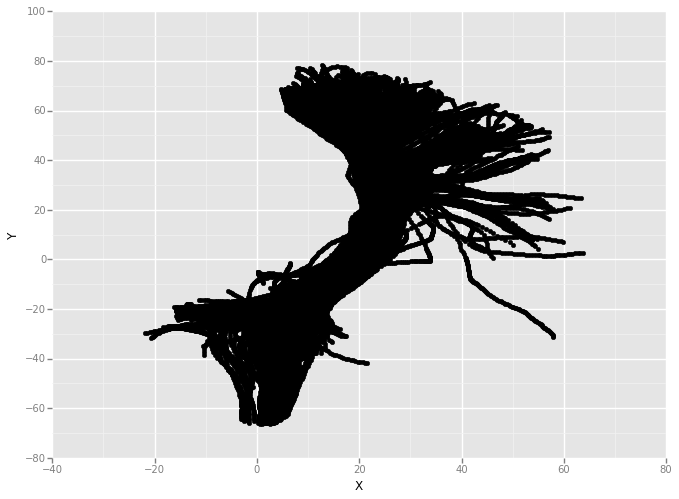

<ggplot: (306759341)>

In [10]:
DF_gs_x = pd.DataFrame(np.transpose([pts[:,0], pts[:,2]]))
DF_gs_x.rename(columns = lambda x: str(x), inplace=True)
DF_gs_x.rename(columns={"0": "X"}, inplace=True) # rename a dfcolumn   
DF_gs_x.rename(columns={"1": "Y"}, inplace=True) # rename a dfcolumn 
DF_gs_x

ggplot(aes(x = 'X', y ='Y'),data=DF_gs_x) + \
    geom_point()

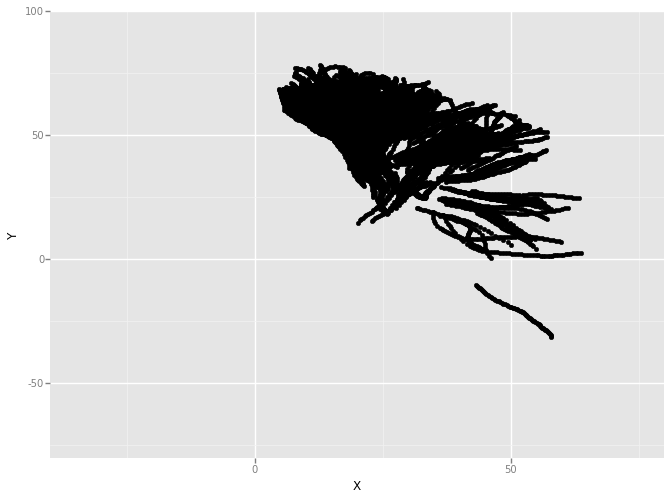

<ggplot: (330136909)>

In [11]:
pts = pts_last_quarter

DF_gs_x = pd.DataFrame(np.transpose([pts[:,0], pts[:,2]]))
DF_gs_x.rename(columns = lambda x: str(x), inplace=True)
DF_gs_x.rename(columns={"0": "X"}, inplace=True) # rename a dfcolumn   
DF_gs_x.rename(columns={"1": "Y"}, inplace=True) # rename a dfcolumn 
DF_gs_x

ggplot(aes(x = 'X', y ='Y'),data=DF_gs_x) + \
    geom_point() \
    + xlim(-40, 80) \
    + ylim(-80, 100)

In [16]:
print((pts[:,0]))

[ 37.39161491  37.89830399  38.39496803 ...,  30.66075706  30.77541542
  30.89007378]


In [ ]:
# gs_cst_fn = '/scratch/TESTS/IpythonNotebook/20160615_HCPWF/mainWF/test_wmql/July31/Baseline_query_cc_3.vtp'
# sr_cst_fn = '/scratch/TESTS/IpythonNotebook/20160615_HCPWF/mainWF/test_wmql/July31/IFFT_query_cc_3.vtp'

In [ ]:
# def ComputeBhattacharyyaCoeficient(baseline_bundle, sr_bundle):
#     import vtk
#     import numpy as np
#     ##
#     def ReturnDistributionInEachCoordinate(bundle):
#         from scipy import stats
#         numPoints = bundle.GetNumberOfPoints()
#         points = bundle.GetPoints()
#         x_arr = np.array([points.GetPoint(i)[0] for i in xrange(numPoints)])
#         y_arr = np.array([points.GetPoint(i)[1] for i in xrange(numPoints)])
#         z_arr = np.array([points.GetPoint(i)[2] for i in xrange(numPoints)])
#         x = np.linspace(x_arr.min(), x_arr.max(), 100)
#         y = np.linspace(y_arr.min(), y_arr.max(), 100)
#         z = np.linspace(z_arr.min(), z_arr.max(), 100)
#         kde_x = stats.gaussian_kde(x_arr)
#         kde_y = stats.gaussian_kde(y_arr)
#         kde_z = stats.gaussian_kde(z_arr)
#         p_x = kde_x(x)
#         p_x = p_x/sum(p_x)
#         p_y = kde_y(y)
#         p_y = p_y/sum(p_y)
#         p_z = kde_z(z)
#         p_z = p_z/sum(p_z)
#         return p_x, p_y, p_z
#     ## read in each fiber bundle
#     reader_gs = vtk.vtkXMLPolyDataReader()
#     reader_gs.SetFileName(baseline_bundle)
#     reader_gs.Update()
#     gs = reader_gs.GetOutput()
#     gs_bundle = reader_gs.GetOutput()
#     #
#     reader_sr = vtk.vtkXMLPolyDataReader()
#     reader_sr.SetFileName(sr_bundle)
#     reader_sr.Update()
#     sr = reader_sr.GetOutput()
#     ## Use ksdensity to estimate probability density function for the sample data in each coordinate
#     [p_gs_x, p_gs_y, p_gs_z] = ReturnDistributionInEachCoordinate(gs)
#     [p_sr_x, p_sr_y, p_sr_z] = ReturnDistributionInEachCoordinate(sr)
#     BC = (1.0/3.0)*( np.sum(np.sqrt(p_gs_x * p_sr_x)) + np.sum(np.sqrt(p_gs_y * p_sr_y)) + np.sum(np.sqrt(p_gs_z * p_sr_z)) )
#     return BC

In [ ]:
# bc = ComputeBhattacharyyaCoeficient(gs_cst_fn,sr_cst_fn)
# print(bc)